# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

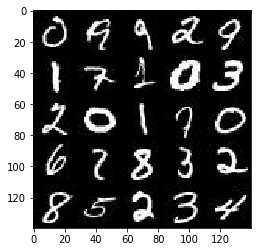

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

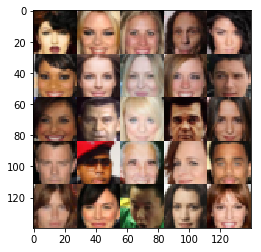

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        layer1 = tf.layers.conv2d(images, 128, 5, strides=1, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn1, bn1)
        
        layer3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn2, bn2)

        flat = tf.reshape(relu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        layer1 = tf.layers.dense(z, 7*7*512)
        
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(layer1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        layer2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        layer3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lrn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lrn_rate = learning_rate
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lrn_rate, beta1)
    
    step_count =0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                step_count += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if step_count%10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step_count%100 == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 16.6148
Epoch 1/2... Discriminator Loss: 0.4584... Generator Loss: 9.8018
Epoch 1/2... Discriminator Loss: 0.3684... Generator Loss: 5.0488
Epoch 1/2... Discriminator Loss: 7.4412... Generator Loss: 0.0020
Epoch 1/2... Discriminator Loss: 0.5718... Generator Loss: 4.5762
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 1.8434
Epoch 1/2... Discriminator Loss: 0.8463... Generator Loss: 1.3307
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 2.0480
Epoch 1/2... Discriminator Loss: 2.0548... Generator Loss: 5.3000
Epoch 1/2... Discriminator Loss: 2.0191... Generator Loss: 4.5585


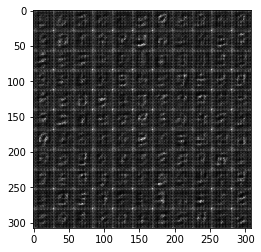

Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 2.3701
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 1.7147
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 1.1236
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.1814
Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 1.5739
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 2.9971
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 1.6260
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 2.8802
Epoch 1/2... Discriminator Loss: 0.8822... Generator Loss: 3.1163


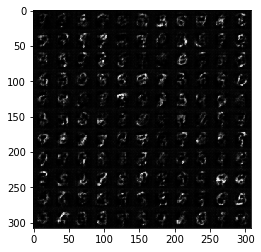

Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 3.4277
Epoch 1/2... Discriminator Loss: 0.6190... Generator Loss: 2.3914
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 2.9630
Epoch 1/2... Discriminator Loss: 0.9576... Generator Loss: 0.9887
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 1.6270
Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 1.1707
Epoch 1/2... Discriminator Loss: 0.7019... Generator Loss: 2.7271
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 1.3271


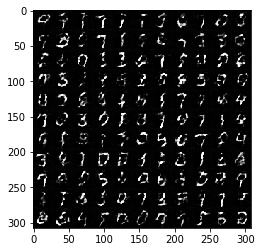

Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 0.7629... Generator Loss: 1.7813
Epoch 1/2... Discriminator Loss: 0.6843... Generator Loss: 2.0281
Epoch 1/2... Discriminator Loss: 0.7745... Generator Loss: 2.2779
Epoch 1/2... Discriminator Loss: 0.6718... Generator Loss: 2.0924
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.4144
Epoch 1/2... Discriminator Loss: 0.8673... Generator Loss: 1.1645
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 2.4029
Epoch 1/2... Discriminator Loss: 2.5945... Generator Loss: 4.9536
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 2.2386


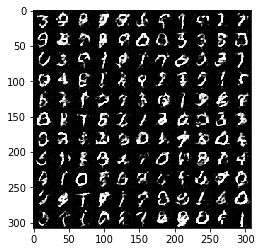

Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 1.2990
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.7220
Epoch 1/2... Discriminator Loss: 5.7295... Generator Loss: 8.0251
Epoch 1/2... Discriminator Loss: 0.9445... Generator Loss: 1.4062
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 1.2838
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 2.5303
Epoch 2/2... Discriminator Loss: 0.9656... Generator Loss: 2.6254
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.7967
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 1.8655
Epoch 2/2... Discriminator Loss: 0.8379... Generator Loss: 1.0847


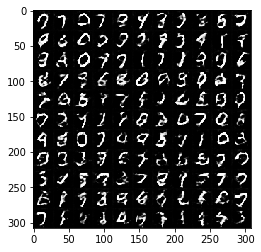

Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.4646... Generator Loss: 3.1849
Epoch 2/2... Discriminator Loss: 1.5835... Generator Loss: 3.9702
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 1.2280
Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 1.9130
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.1043
Epoch 2/2... Discriminator Loss: 0.6947... Generator Loss: 1.3413
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 1.0469
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 1.0605


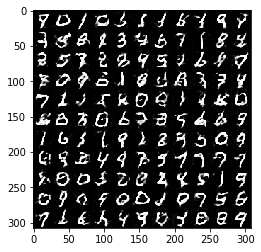

Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 1.6481
Epoch 2/2... Discriminator Loss: 1.3448... Generator Loss: 2.2609
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 1.8571
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 1.1442
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 1.0302
Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 2.5623
Epoch 2/2... Discriminator Loss: 1.5311... Generator Loss: 3.2831
Epoch 2/2... Discriminator Loss: 1.4175... Generator Loss: 0.5163
Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.5021
Epoch 2/2... Discriminator Loss: 1.5889... Generator Loss: 0.4286


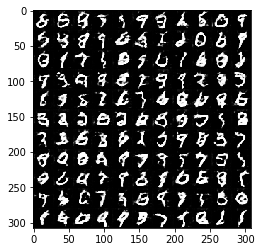

Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 1.6511
Epoch 2/2... Discriminator Loss: 1.9358... Generator Loss: 0.3259
Epoch 2/2... Discriminator Loss: 0.7038... Generator Loss: 1.4015
Epoch 2/2... Discriminator Loss: 0.6478... Generator Loss: 1.6082
Epoch 2/2... Discriminator Loss: 2.1223... Generator Loss: 0.2913
Epoch 2/2... Discriminator Loss: 1.0176... Generator Loss: 1.0008
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 0.6645... Generator Loss: 1.7137
Epoch 2/2... Discriminator Loss: 0.6762... Generator Loss: 1.4010


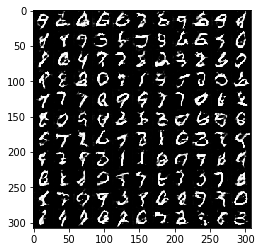

Epoch 2/2... Discriminator Loss: 0.6390... Generator Loss: 1.6807
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 1.9541
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 1.2331
Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 2.0617
Epoch 2/2... Discriminator Loss: 1.1536... Generator Loss: 0.7169
Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 1.6812
Epoch 2/2... Discriminator Loss: 1.4357... Generator Loss: 0.4935
Epoch 2/2... Discriminator Loss: 1.4683... Generator Loss: 3.0152
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.8453
Epoch 2/2... Discriminator Loss: 0.8716... Generator Loss: 1.1947


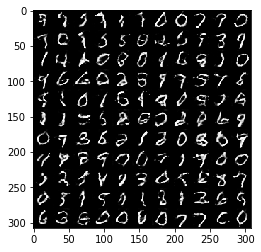

Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 3.1684
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 1.4985
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 1.4994


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.9395... Generator Loss: 0.0103
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 21.2265
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 9.4805
Epoch 1/1... Discriminator Loss: 2.5654... Generator Loss: 0.2691
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 8.9777
Epoch 1/1... Discriminator Loss: 1.6856... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.5789
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.4474
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 3.1141


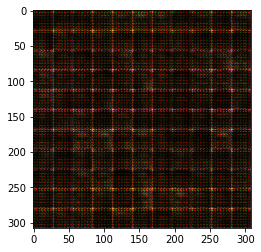

Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 5.3747
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 3.2194
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.3379
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.2145
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 2.0116
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.9824
Epoch 1/1... Discriminator Loss: 1.8667... Generator Loss: 0.3383
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 3.8600


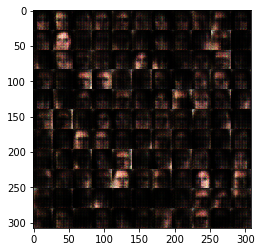

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 2.3447
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.3832
Epoch 1/1... Discriminator Loss: 1.9060... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.9864
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.6111
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 3.0523
Epoch 1/1... Discriminator Loss: 1.9351... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.0866


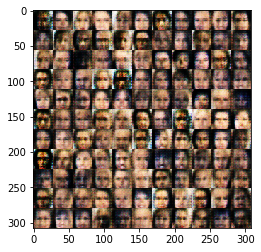

Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 2.1753
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.4433
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.8863
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 2.1428
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.6404


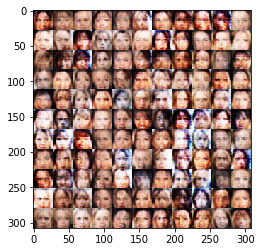

Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 2.0893
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 3.6768
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.9765
Epoch 1/1... Discriminator Loss: 2.0517... Generator Loss: 4.0008
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 2.1308
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 2.8283


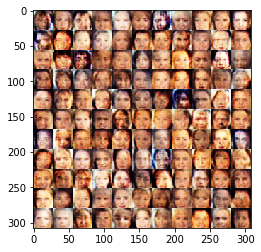

Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 2.3320
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 2.3598
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.5138
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 2.4261
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 3.7308
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 2.6407
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 4.0670
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 2.2802


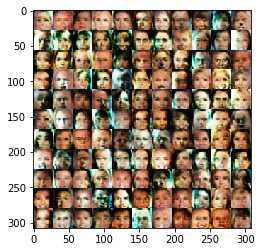

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 4.1577
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 2.1299
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 2.8855
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 4.0877
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.9405
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 1.9654
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.5779
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.5143


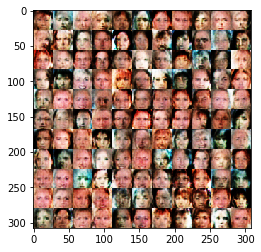

Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 1.8027... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 2.6805
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 1.7889
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 1.8997
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 2.0823
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.7377
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 2.6615
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 2.6606
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.0383


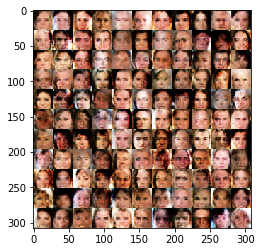

Epoch 1/1... Discriminator Loss: 1.6225... Generator Loss: 4.1156
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 1.7517
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 3.1915
Epoch 1/1... Discriminator Loss: 0.4310... Generator Loss: 4.2758
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 3.2285
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 4.1142
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 1.9364
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 1.9269
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 3.7654
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.6219
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 3.2523
Epoch 1/1.

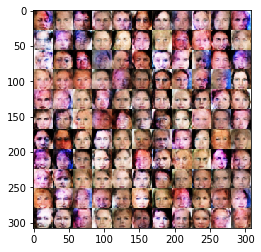

Epoch 1/1... Discriminator Loss: 0.4693... Generator Loss: 2.6486
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 4.8156
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 4.2592
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 1.3733
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 3.0379
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 4.8395
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 2.4650
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 1.7807
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 3.9750


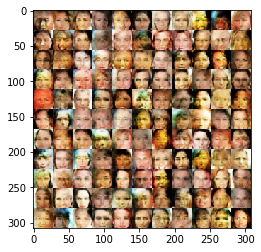

Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 3.4153
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.9974
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 3.4272
Epoch 1/1... Discriminator Loss: 3.7617... Generator Loss: 0.0691
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 1.6884
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.6083
Epoch 1/1... Discriminator Loss: 1.7376... Generator Loss: 0.4027


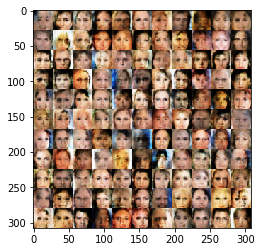

Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.8928
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.9371
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 1.5667
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 2.1624


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.